# Extract boxes with PyTorch

In [1]:
# !pip uninstall -y imgaug && pip install -U imgaug

In [2]:
%load_ext autoreload
%autoreload 2

import os, glob, json, tqdm, pandas, pickle
import matplotlib.pyplot as plt
%pylab inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from imgaug import augmenters as iaa
from imgaug import imgaug as ia
from PIL import Image

from IPython.display import display

from prepare_images_utils import *
from latex_dataset import *

Populating the interactive namespace from numpy and matplotlib


## Prepare data source

In [3]:
SRC_DIR = './generated/src/'

In [4]:
all_image_ids = [os.path.basename(fname)[:-9]
                 for fname in glob.glob(os.path.join(SRC_DIR, '*_out.json'))]
random.shuffle(all_image_ids)

TOTAL_SAMPLES = len(all_image_ids)
TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.8)
VAL_SAMPLES = TOTAL_SAMPLES - TRAIN_SAMPLES
train_image_ids = all_image_ids[:TRAIN_SAMPLES]
val_image_ids = all_image_ids[TRAIN_SAMPLES:]

In [5]:
def load_image_with_boxes(img_id):
    img = load_image_opaque(os.path.join(SRC_DIR, img_id + '_in.png'))
    with open(os.path.join(SRC_DIR, img_id + '_out.json'), 'r') as f:
        boxes = json.load(f)
    return img, boxes


def prepare_img_boxes_for_nn(img, boxes, shape=(600, 600)):
    cats, just_boxes = zip(*boxes)
    cats = numpy.array(cats)
    just_boxes = numpy.array(just_boxes) * POINTS_TO_PIXELS_FACTOR
    just_boxes = just_boxes[:, [1, 0, 3, 2]] # x1, y1, x2, y2
    cropbox = numpy.array((just_boxes[:, 0].min(),
                           just_boxes[:, 1].min(),
                           just_boxes[:, 2].max(),
                           just_boxes[:, 3].max())).astype('int')

    res_in_img = Image.new('L', shape, 255)
    res_in_img.paste(img.crop(cropbox))

    just_boxes -= cropbox[[0, 1, 0, 1]]
    just_boxes = numpy.clip(just_boxes,
                            (0, 0, 0, 0),
                            (shape[0], shape[1], shape[0], shape[1]))
    boxes_area = (just_boxes[:, 2] - just_boxes[:, 0]) * (just_boxes[:, 3] - just_boxes[:, 1])
    good_boxes = numpy.where(boxes_area > 0)[0]
    return (numpy.array(res_in_img).astype('float32') / 255,
            cats[good_boxes],
            just_boxes[good_boxes])


TOTAL_CLASSES = 5
def make_mask_for_nn(size, box_cats, boxes_on_image):
    result = numpy.zeros((TOTAL_CLASSES, ) + size, dtype='float32')
    for cat, bbox in zip(box_cats, boxes_on_image.bounding_boxes):
        result[cat, int(bbox.y1):int(bbox.y2+1), int(bbox.x1):int(bbox.x2+1)] = 1
    return result


def calc_loss_weights(mask, edge_add_weight=0.2, laplacian_ksize=9, edge_th=1.1):
    result = numpy.ones_like(mask)
    for sample_i in range(mask.shape[0]):
        for channel_i in range(mask.shape[1]):
            edges = numpy.absolute(cv2.Laplacian(mask[sample_i, channel_i],
                                                 cv2.CV_32F,
                                                 ksize=laplacian_ksize))
            edges = numpy.where(edges > edge_th, 1, 0)
            if edges.max() > 0:
                result[sample_i, channel_i] += edge_add_weight * edges
    return result


def prepare_batch(batch_image_ids, augmenter):
    images, box_cats, boxes = zip(*[prepare_img_boxes_for_nn(*load_image_with_boxes(img_id))
                                    for img_id in batch_image_ids])

    det = augmenter.to_deterministic() if not augmenter.deterministic else augseq

    images_aug = det.augment_images(images)

    boxes = [ia.BoundingBoxesOnImage([ia.BoundingBox(*box)
                                      for box in img_boxes],
                                     img.shape)
             for img, img_boxes in zip(images, boxes)]
    boxes_aug = det.augment_bounding_boxes(boxes)

    mask = numpy.array([make_mask_for_nn(img.shape, img_box_cats, img_boxes)
                        for img, img_box_cats, img_boxes
                        in zip(images_aug, box_cats, boxes_aug)])

    boxes_aug_lists_with_cats = []
    for img_boxes, img_box_cats in zip(boxes_aug, box_cats):
        img_boxes_with_cats = collections.defaultdict(list)
        for b, c in zip(img_boxes.bounding_boxes, img_box_cats):
            img_boxes_with_cats[c].append((b.x1, b.y1, b.x2, b.y2))
        boxes_aug_lists_with_cats.append(img_boxes_with_cats)

    return (batch_image_ids,
            numpy.expand_dims(numpy.array(images_aug), 1),
            mask,
            calc_loss_weights(mask),
            boxes_aug_lists_with_cats)


def data_gen(image_ids, augmenter, batch_size=32):
    while True:
        yield prepare_batch(numpy.random.choice(image_ids, size=batch_size),
                            augmenter)


class SegmDataset(Dataset):
    def __init__(self, all_image_ids, augmenter):
        self.all_image_ids = all_image_ids
        self.augmenter = augmenter

    def __len__(self):
        return len(self.all_image_ids)

    def __getitem__(self, i):
        (batch_image_ids,
         in_img,
         mask,
         loss_weights,
         boxes_aug) = prepare_batch([self.all_image_ids[i]],
                                    self.augmenter)
        boxes_aug_str = pickle.dumps(boxes_aug[0])
        return (batch_image_ids,
                in_img[0],
                mask[0],
                loss_weights[0],
                boxes_aug_str)

In [7]:
imgaug_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

### Compare data generators

In [8]:
# train_gen_mt = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
#                           batch_size=8,
#                           shuffle=True,
#                           num_workers=4)
# train_gen_mt_iter = iter(train_gen_mt)
# _ = next(train_gen_mt_iter)

In [9]:
# %%prun
# for _ in range(10):
#     next(train_gen_mt_iter)

In [10]:
# train_gen_st = data_gen(train_image_ids, imgaug_pipeline, batch_size=8)
# train_gen_st_iter = iter(train_gen_st)
# _ = next(train_gen_st_iter)

In [11]:
# %%prun
# for _ in range(10):
#     next(train_gen_st_iter)

## Define a network

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilations=[1], bn=True):
        super(ConvBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size,
                                              padding=dil,
                                              dilation=dil)
                                    for dil in dilations])

    def forward(self, x):
        x = self.bn(x)
        return F.relu(torch.cat([conv(x) for conv in self.convs], dim=1))


class UNet(nn.Module):
    def __init__(self, out_channels=TOTAL_CLASSES, first_conv_channels=4, depth=2, out_layers=1, conv_kernel=(3, 3),
                 enc_dilations=[1], dec_dilations=[1]):
        super(UNet, self).__init__()
        enc_channels = [1] + [first_conv_channels * (2**step) for step in range(depth)]
        enc_in_channels = [1] + [n * len(enc_dilations) for n in enc_channels[1:]]
        self.encoder = nn.ModuleList([ConvBlock(enc_in_channels[i],
                                                enc_channels[i+1],
                                                conv_kernel,
                                                dilations=enc_dilations)
                                      for i in range(depth)])
        bottleneck_channels = enc_channels[-1] * 2
        self.bottleneck = ConvBlock(enc_channels[-1],
                                    bottleneck_channels,
                                    conv_kernel,
                                    dilations=enc_dilations)
        dec_channels = [bottleneck_channels] + enc_channels[:0:-1]
        self.dec_conv = nn.ModuleList([ConvBlock(dec_channels[i],
                                                 dec_channels[i+1],
                                                 conv_kernel,
                                                 dilations=dec_dilations)
                                      for i in range(depth)])
        self.dec_deconv = nn.ModuleList([nn.ConvTranspose2d(dec_channels[i],
                                                            dec_channels[i+1],
                                                            (2, 2),
                                                            stride=2)
                                         for i in range(depth)])
        self.out_layers = nn.ModuleList([ConvBlock(dec_channels[-1],
                                                   dec_channels[-1],
                                                   conv_kernel,
                                                   dilations=dec_dilations)])
        self.out_conv = nn.Conv2d(dec_channels[-1],
                                  out_channels,
                                  (1, 1))

    def forward(self, x):
        enc_conv_outs = []
        enc_pool_outs = [x]
        for enc_conv in self.encoder:
            cur_conv_out = enc_conv(enc_pool_outs[-1])
            enc_conv_outs.append(cur_conv_out)
            cur_pool_out = F.max_pool2d(cur_conv_out, (2, 2))
            enc_pool_outs.append(cur_pool_out)

        cur_out = self.bottleneck(enc_pool_outs[-1])

        for dec_step, (dec_conv, dec_deconv) in enumerate(zip(self.dec_conv, self.dec_deconv)):
            up = dec_deconv(cur_out)
            cur_out = torch.cat([up, enc_conv_outs[-dec_step-1]], dim=1)
            cur_out = dec_conv(cur_out)

        for out_layer in self.out_layers:
            cur_out = F.relu(out_layer(cur_out))

        return F.sigmoid(self.out_conv(cur_out))

## Define losses and metrics

### Discrete

In [13]:
def get_all_boxes(mask, min_area=100, min_size=(10, 10), threshold=0.5):
# def get_all_boxes(mask, min_area=0, min_size=(0, 0), threshold=0.5):
    result = []
    contours = cv2.findContours((mask > threshold).astype('uint8'),
                                cv2.RETR_LIST,
                                cv2.CHAIN_APPROX_SIMPLE)[1]
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if h < min_size[0] or w < min_size[1]:
            continue
        result.append((y, x, y+h, x+w))
    result.sort()
    return result


def filter_by_intersection(big_box, boxes_to_filter, threshold=0.8):
    return [b for b in boxes_to_filter
            if box_inter_area(big_box, b) / box_area(b) >= threshold]


def get_biggest_box(boxes):
    return boxes[numpy.argmax(list(map(box_area, boxes)))]


def get_boxes_by_channel(pred):
    pred_boxes = [[]]
    pred_boxes.append(get_all_boxes(pred[1]))
    pred_body = get_biggest_box(pred_boxes[1])
    for ch in range(2, TOTAL_CLASSES):
        pred_boxes.append(filter_by_intersection(pred_body, get_all_boxes(pred[ch])))
    return pred_boxes


def find_closest_box(box, others, min_dice=0.8):
    ba = box_area(box)
    best_dice = 0
    best_idx = None
    for i, other in enumerate(others):
        dice = 2 * box_inter_area(box, other) / (ba + box_area(other))
        if dice > best_dice:
            best_idx = i
            best_dice = dice
    return best_idx


def classify_boxes(pred_boxes, gold_boxes, strictness=0.8):
    true_positive = []
    false_positive = []

    found_gold = set()
    for i, box in enumerate(pred_boxes):
        closest_gold_i = find_closest_box(box, gold_boxes, min_dice=strictness)
        if not closest_gold_i is None:
            true_positive.append(i)
            found_gold.add(closest_gold_i)
        else:
            false_positive.append(i)

    false_negative = set(range(len(gold_boxes))) - found_gold
    return (true_positive, false_positive, false_negative)


def calc_precision(tp, fp, fn):
    denom = float(tp + fp)
    return (tp / denom) if denom > 1e-4 else 0


def calc_recall(tp, fp, fn):
    denom = float(tp + fn)
    return (tp / denom) if denom > 1e-4 else 0


def box_match_single_image(pred, gold_boxes, metric, strictness=0.8):
    pred_boxes = get_boxes_by_channel(pred)
    result = []
    for ch in range(pred.shape[0]):
        tp, fp, fn = classify_boxes(pred_boxes[ch],
                                    gold_boxes.get(ch, []),
                                    strictness=strictness)
        tp, fp, fn = len(tp), len(fp), len(fn)
        result.append(metric(tp, fp, fn))
    return result

def box_match_batch(pred, gold_boxes, metric, strictness=0.8):
    if not isinstance(pred, numpy.ndarray):
        pred = pred.data.cpu().numpy()
    image_metrics = [box_match_single_image(pred[i],
                                            gold_boxes[i],
                                            metric,
                                            strictness=strictness)
                     for i in range(pred.shape[0])]
    return numpy.array(image_metrics).mean(0)


def box_match_precision(pred, target, gold_boxes, strictness=0.8):
    return box_match_batch(pred, gold_boxes, calc_precision, strictness=strictness)


def box_match_recall(pred, target, gold_boxes, strictness=0.8):
    return box_match_batch(pred, gold_boxes, calc_recall, strictness=strictness)

# box_match_precision(numpy.tile(numpy.array([[[[1, 1, 1, 1], [1, 1, 1, 1]]]]), (1, 5, 1, 1)),
#                     None,
#                     [{2 : [[0, 0, 2, 4]]}])

### Fuzzy

$Dice(p, t, w) = 1 - \frac{ p \cdot t + 1 }{ p + t + 1 }$

$WDice(p, t, w) = 1 - \frac{ p \cdot t \cdot w^{-1} + 1 }{ p + t + p \cdot (1 - t) \cdot w + 1 }$

In [14]:
DICE_SMOOTH = 1.0
def dice_coef(pred, target, gold_boxes):
    intersection = pred * target
    union = pred + target
    return ((2. * intersection.sum(3).sum(2).sum(0) + DICE_SMOOTH) /
            (union.sum(3).sum(2).sum(0) + DICE_SMOOTH))


def px_precision(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fp = ((target - pred) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fp
    return tp / (denum + (denum == 0).float())


def px_recall(pred, target, threshold=0.5):
    pred = pred >= threshold
    target = target >= threshold
    tp = (pred * target).float().sum(3).sum(2).sum(0)
    fn = ((pred - target) < 0).float().sum(3).sum(2).sum(0)
    denum = tp + fn
    return tp / (denum + (denum == 0).float())


def make_single_channel(f, channel):
    def _impl(pred, target):
        return f(pred[:, channel:channel+1], target[:, channel:channel+1])
    return _impl


def make_cpu(f):
    def _impl(pred, target):
        return f(pred.cpu(), target.cpu())
    return _impl


METRICS_DIMENSIONS_MEANING = (None, 'area', 'cell', 'rows', 'cols')
METRICS = {'d' : (dice_coef, METRICS_DIMENSIONS_MEANING),
           'bp' : (box_match_precision, METRICS_DIMENSIONS_MEANING),
           'br' : (box_match_recall, METRICS_DIMENSIONS_MEANING),
#            'p' : px_precision,
#            'r' : px_recall
           }
# for channel in range(1, TOTAL_CLASSES):
#     METRICS['d{}'.format(channel)] = make_single_channel(make_cpu(dice_coef), channel)
#     METRICS['pp{}'.format(channel)] = make_single_channel(px_precision, channel)
#     METRICS['pr{}'.format(channel)] = make_single_channel(px_recall, channel)

### Losses

In [15]:
def dice_loss(pred, target, weights):
    intersection = pred * target
    union = pred + target
    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def weighted_dice_loss(pred, target, weights):
    # the idea is to lower actual intersection in important areas
    inv_weights = 1 / weights
    intersection = pred * inv_weights * target
    
    # the idea is to increase actual predicted values
    # where they have to be zero
    inv_target = 1 - target
    inv_intersection = pred * inv_target * weights
    union = pred + target + inv_intersection

    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))


def dice_bce_loss(pred, target, weights):
    return dice_loss(pred, target, weights) + F.binary_cross_entropy(pred, target, weights)

## Train

In [16]:
def mcuda(x, cuda):
    return x.cuda() if cuda else x


def npten(arr, cuda):
    return mcuda(torch.from_numpy(arr), cuda)


def npvar(arr, cuda):
    if not torch.is_tensor(arr):
        arr = torch.from_numpy(arr)
    return mcuda(Variable(arr), cuda)


def run_network(network, generator, num_batches, criterion=dice_bce_loss, optimizer=None, cuda=True):
    metrics = []
    gen_iter = iter(generator)
    for _ in tqdm.tqdm(range(num_batches)):
        image_ids, images, mask, loss_weights, boxes = next(gen_iter)
        images_var = npvar(images, cuda)
        mask_var = npvar(mask, cuda)
        loss_weights_var = npvar(loss_weights, cuda)
        boxes = [pickle.loads(b) for b in boxes]

        cur_out = network(images_var)

        loss = criterion(cur_out, mask_var, loss_weights_var)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm(network.parameters(), 10)
            optimizer.step()

        cur_metrics = { 'loss' : loss.data[0] }
        for name, (func, elem_names) in METRICS.items():
            metric_value = func(cur_out, mask_var, boxes)
            if not isinstance(metric_value, (list, numpy.ndarray)):
                metric_value = metric_value.cpu().data.numpy()
            cur_metrics.update(('\n'.join((name, n)), v) for n, v in zip(elem_names, metric_value) if n)
        metrics.append(cur_metrics)
    return metrics

### Run

In [17]:
train_gen = None
val_gen = None

EPOCHS_NUM = 60
BATCH_SIZE = 16
PART_PER_EPOCH = 0.5
BATCHES_PER_EPOCH_TRAIN = int(len(train_image_ids) * PART_PER_EPOCH / BATCH_SIZE)
BATCHES_PER_EPOCH_VAL = int(len(val_image_ids) * PART_PER_EPOCH // BATCH_SIZE)

# train_gen = data_gen(train_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)
# val_gen = data_gen(val_image_ids, imgaug_pipeline, batch_size=BATCH_SIZE)


net = UNet(first_conv_channels=8,
           depth=3,
           enc_dilations=[1]).cuda()
# LOSS = dice_bce_loss
# LOSS = dice_loss
LOSS = weighted_dice_loss
print('total parameters', sum(numpy.product(p.size()) for p in net.parameters()))

train_metrics = []
val_metrics = []
for epoch in range(EPOCHS_NUM):
    try:
        train_gen = DataLoader(SegmDataset(train_image_ids, imgaug_pipeline),
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=0)
        val_gen = DataLoader(SegmDataset(val_image_ids, imgaug_pipeline),
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=0)
        print('epoch', epoch)

        lr_factor = 0.5 ** (epoch // 20)
        lr = 1e-3 * lr_factor
        print('lr', lr)
        optimizer = Adam(net.parameters(), lr=lr)

        net.train()
        cur_train_metrics = run_network(net, train_gen, BATCHES_PER_EPOCH_TRAIN,
                                        criterion=LOSS,
                                        optimizer=optimizer)
        train_metrics.extend(cur_train_metrics)
        display(pandas.DataFrame(cur_train_metrics).describe().loc[['mean', 'std']])

        net.eval()
        cur_val_metrics = run_network(net, val_gen, BATCHES_PER_EPOCH_VAL,
                                      criterion=LOSS)
        val_metrics.extend(cur_val_metrics)
        display(pandas.DataFrame(cur_val_metrics).describe().loc[['mean', 'std']])
    finally:
        if train_gen:
            del train_gen
        if val_gen:
            del val_gen

  0%|          | 0/75 [00:00<?, ?it/s]

total parameters 60423
epoch 0
lr 0.001


100%|██████████| 75/75 [04:24<00:00,  3.52s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.762091,0.683953,0.423846,0.599653,1.0,0.092375,0.205252,0.253843,0.342920,0.138892,0.258902,0.219823,0.881110
std,0.234034,0.284958,0.427247,0.342422,0.0,0.076180,0.214344,0.192446,0.071743,0.044237,0.063266,0.069920,0.037042


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.864352,0.842477,0.856771,0.851852,1.0,0.063338,0.339368,0.209160,0.457947,0.236154,0.393911,0.349710,0.807352
std,0.051225,0.054104,0.053061,0.058414,0.0,0.006285,0.029482,0.017687,0.028310,0.012336,0.026260,0.020748,0.015036


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 1
lr 0.001


100%|██████████| 75/75 [01:35<00:00,  1.27s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.864569,0.856909,0.868417,0.870373,1.0,0.063060,0.332436,0.206055,0.673243,0.374599,0.560088,0.503379,0.652443
std,0.063411,0.061154,0.084741,0.061487,0.0,0.007389,0.034570,0.021777,0.141662,0.078833,0.112214,0.098387,0.109158


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.859565,0.83244,0.856729,0.856382,1.0,0.067578,0.347090,0.215524,0.905662,0.484947,0.774550,0.64846,0.440718
std,0.058380,0.07439,0.060958,0.059969,0.0,0.007318,0.021932,0.016022,0.010932,0.015516,0.020992,0.01722,0.014173


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 2
lr 0.001


100%|██████████| 75/75 [01:40<00:00,  1.33s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.884982,0.293769,0.886302,0.882500,1.0,0.119024,0.346431,0.219009,0.947168,0.529475,0.853514,0.674227,0.331562
std,0.053254,0.291527,0.054075,0.055085,0.0,0.119229,0.029809,0.021329,0.021946,0.136748,0.042878,0.023592,0.057448


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.858747,0.336629,0.858747,0.847809,1.0,0.267493,0.366518,0.222144,0.950608,0.808829,0.864156,0.667374,0.295918
std,0.042113,0.040568,0.042113,0.043914,0.0,0.029372,0.039195,0.022407,0.006990,0.003088,0.013644,0.021633,0.008089


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 3
lr 0.001


100%|██████████| 75/75 [01:46<00:00,  1.42s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.862850,0.330119,0.862794,0.834015,1.0,0.26718,0.359646,0.278740,0.966719,0.899830,0.904308,0.699792,0.235454
std,0.054162,0.037129,0.054637,0.088434,0.0,0.02500,0.029501,0.124496,0.007373,0.035738,0.009953,0.027391,0.018780


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.854365,0.333190,0.849851,0.595447,1.0,0.269514,0.365187,0.630563,0.894858,0.894689,0.807813,0.717486,0.313862
std,0.064770,0.035493,0.056246,0.046289,0.0,0.021423,0.036063,0.027324,0.013477,0.005088,0.018943,0.010824,0.020034


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 4
lr 0.001


100%|██████████| 75/75 [01:47<00:00,  1.43s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.831380,0.326668,0.759472,0.579770,1.0,0.268314,0.382390,0.656053,0.970582,0.942161,0.906562,0.815784,0.151274
std,0.080142,0.037067,0.109940,0.059324,0.0,0.025661,0.049021,0.035128,0.006626,0.009203,0.010576,0.026478,0.016790


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.882581,0.334059,0.604635,0.494113,1.0,0.270818,0.436741,0.675322,0.970426,0.953639,0.911165,0.826309,0.133932
std,0.058553,0.038349,0.074331,0.046796,0.0,0.023136,0.041586,0.030211,0.007397,0.002050,0.008096,0.011090,0.006401


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 5
lr 0.001


100%|██████████| 75/75 [01:48<00:00,  1.45s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.886208,0.332473,0.638134,0.507187,1.0,0.273226,0.419615,0.678636,0.972778,0.954771,0.919947,0.839501,0.123583
std,0.059353,0.041192,0.073850,0.064719,0.0,0.027326,0.048199,0.035850,0.006870,0.006057,0.009636,0.018653,0.009010


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.891262,0.330715,0.637566,0.502967,1.0,0.270362,0.42152,0.664790,0.972811,0.947802,0.924950,0.845041,0.118676
std,0.059720,0.022259,0.065404,0.046063,0.0,0.019080,0.03614,0.024819,0.005311,0.002486,0.007665,0.011224,0.005946


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 6
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.888136,0.332916,0.652327,0.482077,1.0,0.274677,0.401297,0.694342,0.974932,0.961895,0.934314,0.851104,0.108128
std,0.055337,0.040830,0.078192,0.055445,0.0,0.029490,0.042661,0.035067,0.005891,0.004889,0.008900,0.013836,0.007103


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.886400,0.334105,0.642929,0.486957,1.0,0.276170,0.404657,0.692219,0.973120,0.958676,0.933893,0.862305,0.105354
std,0.038339,0.045283,0.058154,0.065074,0.0,0.032561,0.045363,0.040106,0.006366,0.002586,0.007726,0.009578,0.005638


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 7
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.892171,0.330887,0.653863,0.477692,1.0,0.273266,0.381390,0.687614,0.976189,0.965161,0.939215,0.862698,0.102846
std,0.052727,0.038219,0.073064,0.055169,0.0,0.027028,0.037561,0.034188,0.006171,0.004001,0.008808,0.013940,0.007095


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.911343,0.332788,0.661133,0.473468,1.0,0.272609,0.392585,0.696161,0.972803,0.967174,0.935551,0.858265,0.104617
std,0.044486,0.036453,0.067534,0.033395,0.0,0.026253,0.040889,0.031729,0.004912,0.002196,0.006534,0.010902,0.005449


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 8
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898603,0.321680,0.643718,0.466890,1.0,0.267066,0.381436,0.690552,0.975773,0.967815,0.940380,0.867331,0.100966
std,0.051625,0.033509,0.061126,0.042529,0.0,0.024087,0.037288,0.033198,0.007119,0.003531,0.008709,0.013459,0.006939


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.897685,0.332754,0.644702,0.480130,1.0,0.273625,0.401839,0.693061,0.973422,0.963838,0.935750,0.858855,0.103152
std,0.045695,0.044905,0.063158,0.042829,0.0,0.033044,0.038261,0.025677,0.005626,0.001945,0.007307,0.008827,0.005990


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 9
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893833,0.326232,0.643356,0.475266,1.0,0.272001,0.379287,0.693274,0.976039,0.969428,0.941392,0.871331,0.099622
std,0.051048,0.037228,0.070771,0.050707,0.0,0.025680,0.036108,0.029865,0.007020,0.002859,0.009329,0.013874,0.007207


100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.625831,0.329105,0.550935,0.466410,1.0,0.269542,0.419252,0.705218,0.288618,0.971408,0.777639,0.870420,0.691383
std,0.058516,0.037572,0.066946,0.033021,0.0,0.028019,0.050555,0.026754,0.026214,0.001925,0.021383,0.007634,0.026745


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 10
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896498,0.331147,0.635178,0.473866,1.0,0.274700,0.383821,0.696217,0.976104,0.970039,0.942744,0.873708,0.098274
std,0.056033,0.039611,0.074542,0.052407,0.0,0.027458,0.035927,0.034258,0.006071,0.002633,0.007173,0.011524,0.005288


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.871354,0.335352,0.643733,0.484786,1.0,0.278069,0.381118,0.689559,0.973057,0.971858,0.943458,0.880884,0.101388
std,0.044823,0.040195,0.078724,0.069012,0.0,0.033488,0.038861,0.030656,0.005466,0.001801,0.006065,0.006756,0.004700


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 11
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.895340,0.323539,0.632410,0.470095,1.0,0.268491,0.377016,0.697246,0.977044,0.971219,0.943366,0.877349,0.097336
std,0.052021,0.037718,0.073275,0.059968,0.0,0.027821,0.037558,0.033121,0.005868,0.002811,0.007836,0.011991,0.006541


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.914525,0.313424,0.629402,0.453566,1.0,0.259763,0.373625,0.687629,0.972852,0.972461,0.941224,0.880853,0.098942
std,0.041643,0.029094,0.078069,0.047190,0.0,0.020372,0.032712,0.034503,0.006392,0.002488,0.005105,0.006090,0.003644


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 12
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893413,0.330049,0.607936,0.479954,1.0,0.274266,0.388363,0.701967,0.975760,0.972136,0.943219,0.880058,0.096671
std,0.049293,0.038348,0.070196,0.056102,0.0,0.028550,0.042802,0.036962,0.005781,0.002333,0.007549,0.011076,0.006139


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893519,0.320778,0.603843,0.443981,1.0,0.265390,0.370114,0.690788,0.975105,0.973816,0.943105,0.877909,0.098064
std,0.046344,0.020248,0.061405,0.035218,0.0,0.016816,0.032163,0.036045,0.006358,0.002029,0.007832,0.012083,0.006196


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 13
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894712,0.321082,0.586784,0.467959,1.0,0.268045,0.392333,0.701015,0.977176,0.972445,0.944534,0.881393,0.095450
std,0.054147,0.033844,0.061415,0.045387,0.0,0.024463,0.038853,0.033040,0.006339,0.002714,0.007232,0.010068,0.005966


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893444,0.333591,0.570675,0.449454,1.0,0.275367,0.399777,0.699350,0.973756,0.972407,0.941790,0.863931,0.097927
std,0.043525,0.040853,0.076892,0.057570,0.0,0.027989,0.037076,0.031875,0.005871,0.002149,0.007632,0.010086,0.005971


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 14
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901528,0.321070,0.572813,0.460652,1.0,0.267719,0.394725,0.699648,0.976837,0.972994,0.945054,0.881801,0.094919
std,0.050388,0.041829,0.065213,0.056699,0.0,0.029757,0.039220,0.034824,0.006642,0.002244,0.007652,0.012397,0.006242


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.888657,0.321636,0.551744,0.443961,1.0,0.268332,0.406391,0.710838,0.969569,0.971317,0.939317,0.866567,0.099585
std,0.035256,0.051330,0.066021,0.057503,0.0,0.034046,0.045939,0.043336,0.007811,0.001937,0.008919,0.011885,0.008297


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 15
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898087,0.326405,0.560325,0.466154,1.0,0.273410,0.401002,0.698852,0.977068,0.973169,0.945388,0.885468,0.094002
std,0.059608,0.040911,0.070923,0.057365,0.0,0.028646,0.042638,0.032405,0.005966,0.002458,0.007174,0.012224,0.005650


100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.468989,0.328047,0.584709,0.456195,1.0,0.266727,0.596525,0.715112,0.291677,0.97483,0.295236,0.877402,0.783707
std,0.037776,0.032345,0.059670,0.038607,0.0,0.023406,0.054007,0.034548,0.027760,0.00274,0.028210,0.008323,0.021898


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 16
lr 0.001


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896729,0.322842,0.548774,0.488921,1.0,0.270742,0.404839,0.689134,0.976870,0.973365,0.944991,0.890409,0.093456
std,0.049906,0.029282,0.065283,0.057873,0.0,0.022767,0.035010,0.036990,0.007135,0.002261,0.008132,0.012528,0.006527


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.578065,0.340512,0.562306,0.573768,1.0,0.279273,0.59100,0.686439,0.303059,0.973475,0.274560,0.871352,0.787287
std,0.071110,0.037449,0.074861,0.044398,0.0,0.025818,0.05142,0.027168,0.035722,0.002001,0.033015,0.005614,0.025515


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 17
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901188,0.321626,0.569064,0.572102,1.0,0.270234,0.399250,0.665429,0.977317,0.973450,0.944912,0.905020,0.090365
std,0.048783,0.034586,0.062538,0.045748,0.0,0.025384,0.041555,0.032069,0.005531,0.002267,0.006692,0.009051,0.005473


100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.606415,0.320637,0.621728,0.623903,1.0,0.265935,0.651648,0.697364,0.292032,0.973301,0.337739,0.176710,0.832259
std,0.064799,0.034026,0.068481,0.047337,0.0,0.023818,0.056826,0.028639,0.035249,0.001753,0.040055,0.021853,0.022882


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 18
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898649,0.322034,0.566083,0.577437,1.0,0.270174,0.402515,0.668415,0.977781,0.973801,0.945310,0.905240,0.089518
std,0.051689,0.031937,0.057047,0.048338,0.0,0.023696,0.039438,0.029569,0.006298,0.002171,0.007183,0.010408,0.006026


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.888657,0.329750,0.568906,0.588446,1.0,0.275347,0.427680,0.683203,0.975701,0.974865,0.944540,0.900738,0.090806
std,0.054578,0.047198,0.054164,0.058672,0.0,0.033839,0.046581,0.032333,0.004667,0.001368,0.005298,0.007936,0.004382


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 19
lr 0.001


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899806,0.326502,0.575226,0.579216,1.0,0.274090,0.405993,0.671729,0.977738,0.974520,0.945894,0.906265,0.088838
std,0.051130,0.034725,0.063625,0.048412,0.0,0.025853,0.041064,0.027614,0.005402,0.002354,0.006671,0.009815,0.005697


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901157,0.324063,0.548457,0.545257,1.0,0.272230,0.419564,0.667227,0.972708,0.972962,0.939294,0.887051,0.092906
std,0.046326,0.020670,0.048826,0.042732,0.0,0.013367,0.029333,0.025226,0.008588,0.002292,0.008468,0.008620,0.006732


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 20
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899315,0.322531,0.569781,0.583363,1.0,0.270837,0.405789,0.669351,0.979175,0.974557,0.948818,0.909463,0.086664
std,0.050514,0.039565,0.065482,0.048492,0.0,0.028061,0.036698,0.027833,0.006271,0.002241,0.007349,0.009457,0.005481


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.888947,0.332004,0.580841,0.571767,1.0,0.276915,0.416424,0.674567,0.970798,0.975952,0.941189,0.900697,0.091724
std,0.054206,0.038258,0.058235,0.036865,0.0,0.027947,0.041897,0.031110,0.007508,0.001859,0.008069,0.010382,0.006286


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 21
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893965,0.324446,0.568640,0.577026,1.0,0.272709,0.400305,0.669124,0.97858,0.975406,0.947389,0.908601,0.087332
std,0.047141,0.034418,0.071616,0.052626,0.0,0.025349,0.041110,0.026326,0.00590,0.001947,0.007181,0.009832,0.006014


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899372,0.323895,0.579594,0.581909,1.0,0.271149,0.405725,0.67631,0.976168,0.975765,0.944477,0.910445,0.089715
std,0.040866,0.037637,0.070363,0.042237,0.0,0.029193,0.044914,0.02681,0.006155,0.002494,0.007747,0.007723,0.006182


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 22
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900947,0.323253,0.561851,0.585281,1.0,0.272314,0.403344,0.671163,0.978501,0.975672,0.947276,0.910202,0.086982
std,0.053921,0.035648,0.055174,0.051035,0.0,0.026993,0.038890,0.030131,0.006392,0.002207,0.007435,0.008374,0.005754


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896007,0.330431,0.587359,0.573010,1.0,0.276548,0.416977,0.663096,0.976544,0.975368,0.945247,0.905943,0.087507
std,0.061784,0.040375,0.058370,0.048596,0.0,0.030007,0.033101,0.022879,0.007247,0.002111,0.008068,0.008165,0.007203


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 23
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.892802,0.326767,0.573685,0.575645,1.0,0.275148,0.408255,0.668292,0.977997,0.975462,0.946899,0.908869,0.087360
std,0.053906,0.033505,0.070463,0.048549,0.0,0.025894,0.037976,0.028269,0.006488,0.002190,0.006855,0.010100,0.005774


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.592072,0.317700,0.583737,0.539095,1.0,0.261776,0.564431,0.688059,0.298731,0.975622,0.287401,0.886107,0.782309
std,0.065242,0.036513,0.055927,0.041754,0.0,0.026454,0.050823,0.033923,0.029910,0.002324,0.029139,0.005566,0.022993


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 24
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894316,0.321228,0.567168,0.576554,1.0,0.269747,0.401193,0.669649,0.978704,0.975505,0.947572,0.910742,0.086717
std,0.056731,0.035849,0.062151,0.050006,0.0,0.025561,0.043640,0.029642,0.005481,0.002174,0.006870,0.008240,0.005347


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.880556,0.320074,0.551740,0.569723,1.0,0.269403,0.406724,0.667583,0.974725,0.976291,0.944919,0.910281,0.089443
std,0.044206,0.035135,0.058514,0.042426,0.0,0.023010,0.047774,0.034788,0.007154,0.002713,0.007064,0.007855,0.004684


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 25
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.897019,0.319628,0.568198,0.576879,1.0,0.268570,0.398899,0.668648,0.977894,0.975701,0.946948,0.909533,0.087300
std,0.045817,0.038651,0.063809,0.041830,0.0,0.026623,0.036215,0.029496,0.006014,0.002450,0.007752,0.007679,0.005683


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.800587,0.328062,0.553854,0.588020,1.0,0.274387,0.408913,0.667889,0.949019,0.975148,0.947344,0.912646,0.108799
std,0.063472,0.030556,0.054816,0.027928,0.0,0.024763,0.041399,0.024208,0.004889,0.001695,0.006442,0.007447,0.003981


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 26
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894643,0.327588,0.572344,0.586796,1.0,0.276085,0.409289,0.670490,0.979063,0.975970,0.948802,0.912333,0.085660
std,0.049343,0.034361,0.059027,0.042015,0.0,0.025608,0.039440,0.027748,0.005977,0.001855,0.007012,0.009570,0.005601


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.889707,0.316364,0.547579,0.558161,1.0,0.266421,0.403016,0.678176,0.974852,0.975871,0.943912,0.905720,0.089750
std,0.030411,0.036858,0.064761,0.047485,0.0,0.026302,0.034667,0.024957,0.006654,0.002303,0.007498,0.007768,0.005115


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 27
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901490,0.322175,0.565811,0.581760,1.0,0.272553,0.402647,0.673308,0.978488,0.975974,0.947783,0.911644,0.086408
std,0.048523,0.037033,0.057072,0.046616,0.0,0.026846,0.035487,0.030337,0.005296,0.002174,0.006817,0.009744,0.004960


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893403,0.329113,0.550167,0.558096,1.0,0.273895,0.419169,0.676086,0.976516,0.974848,0.944844,0.899903,0.088820
std,0.051906,0.038408,0.058970,0.054283,0.0,0.025800,0.045923,0.028627,0.006210,0.002748,0.007605,0.009237,0.005746


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 28
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898362,0.320708,0.575135,0.576808,1.0,0.269670,0.401921,0.66817,0.978624,0.976090,0.948062,0.911743,0.086208
std,0.052116,0.036445,0.070003,0.052906,0.0,0.027686,0.037621,0.02793,0.005622,0.001862,0.006902,0.009938,0.005724


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.837632,0.316078,0.558084,0.550467,1.0,0.265927,0.410665,0.676541,0.974510,0.975766,0.946672,0.912048,0.091027
std,0.078293,0.027391,0.057940,0.059775,0.0,0.017923,0.032907,0.031143,0.005095,0.001939,0.006796,0.009516,0.005899


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 29
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894724,0.325199,0.563559,0.584077,1.0,0.273638,0.400930,0.671440,0.978716,0.975937,0.948437,0.912377,0.085749
std,0.045772,0.036984,0.065776,0.045302,0.0,0.025653,0.038201,0.030041,0.005554,0.002023,0.006266,0.008922,0.005129


100%|██████████| 18/18 [00:23<00:00,  1.28s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.532553,0.311428,0.508198,0.545305,1.0,0.260359,0.404758,0.639197,0.493437,0.976344,0.942092,0.905513,0.474483
std,0.048418,0.055777,0.084178,0.067693,0.0,0.038620,0.063952,0.056693,0.043309,0.002232,0.005883,0.008464,0.038969


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 30
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899653,0.315138,0.562202,0.575694,1.0,0.266781,0.392362,0.665328,0.979543,0.976347,0.949401,0.914311,0.085276
std,0.052501,0.032837,0.061536,0.049712,0.0,0.024007,0.034098,0.028909,0.005003,0.001879,0.006258,0.009743,0.004781


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.541551,0.332412,0.571959,0.569653,1.0,0.277297,0.416733,0.676964,0.949733,0.976140,0.943830,0.903229,0.114191
std,0.074108,0.034119,0.081467,0.045120,0.0,0.023355,0.030268,0.036201,0.004370,0.001915,0.007704,0.007905,0.004412


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 31
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900165,0.321328,0.575301,0.581588,1.0,0.271554,0.403538,0.664632,0.978836,0.976276,0.948755,0.913020,0.085456
std,0.048339,0.031175,0.055205,0.047742,0.0,0.023733,0.039479,0.030035,0.005905,0.002173,0.007586,0.009649,0.005961


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.907168,0.331347,0.57732,0.580500,1.0,0.276555,0.412752,0.674370,0.975432,0.977011,0.946170,0.91489,0.088185
std,0.054520,0.041392,0.06927,0.051311,0.0,0.029314,0.043477,0.040382,0.005715,0.001707,0.005704,0.00815,0.004720


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 32
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900815,0.323732,0.575747,0.577774,1.0,0.272365,0.407920,0.667847,0.978213,0.976505,0.947884,0.913277,0.085833
std,0.048359,0.037043,0.069410,0.046951,0.0,0.026993,0.040308,0.028761,0.006193,0.002624,0.007221,0.009228,0.006103


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893229,0.343439,0.579522,0.590515,1.0,0.287328,0.423698,0.678348,0.974068,0.977025,0.94465,0.910582,0.087845
std,0.055957,0.030330,0.050461,0.040568,0.0,0.021424,0.030747,0.030885,0.005588,0.002033,0.00629,0.007606,0.004572


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 33
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.895343,0.325573,0.571631,0.579906,1.0,0.274657,0.408779,0.670642,0.979196,0.976561,0.948781,0.913468,0.085207
std,0.054149,0.033652,0.059636,0.045614,0.0,0.025066,0.037870,0.032298,0.005284,0.002009,0.006781,0.009555,0.005240


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.906068,0.326518,0.589567,0.578589,1.0,0.27490,0.418089,0.670604,0.976814,0.978395,0.947575,0.912620,0.087175
std,0.049237,0.033448,0.048738,0.044806,0.0,0.02263,0.032397,0.023201,0.007099,0.001855,0.008568,0.011106,0.007149


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 34
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901002,0.323529,0.558849,0.585415,1.0,0.273292,0.401208,0.666031,0.979222,0.976900,0.950171,0.914598,0.084305
std,0.047736,0.039620,0.066930,0.048112,0.0,0.029639,0.038931,0.027613,0.005782,0.001914,0.006532,0.009770,0.005578


100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.874095,0.331153,0.578677,0.573889,1.0,0.276966,0.419461,0.689150,0.947512,0.976995,0.949409,0.911043,0.107741
std,0.052686,0.032572,0.048930,0.044333,0.0,0.023755,0.031329,0.023297,0.005613,0.001582,0.007037,0.009489,0.004909


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 35
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.908264,0.322513,0.566785,0.574977,1.0,0.271970,0.400375,0.660775,0.978803,0.976371,0.948439,0.912608,0.085602
std,0.048627,0.032103,0.055323,0.043828,0.0,0.024497,0.038207,0.026844,0.006620,0.002368,0.007587,0.010532,0.006610


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893535,0.325851,0.562504,0.573686,1.0,0.274162,0.404277,0.670243,0.975035,0.977121,0.944127,0.907047,0.088643
std,0.057415,0.042227,0.069820,0.056193,0.0,0.030413,0.048183,0.033172,0.004905,0.001788,0.007001,0.005594,0.004698


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 36
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900653,0.325289,0.578015,0.582782,1.0,0.274529,0.404608,0.669256,0.979520,0.976939,0.949732,0.915472,0.084105
std,0.046854,0.037264,0.062156,0.047341,0.0,0.027626,0.033563,0.027326,0.005866,0.002303,0.006287,0.009016,0.005033


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.904977,0.315545,0.562751,0.562576,1.0,0.265452,0.392128,0.668603,0.975558,0.976983,0.947284,0.909581,0.087241
std,0.051933,0.036141,0.058869,0.049565,0.0,0.026910,0.036356,0.027736,0.005363,0.001815,0.007165,0.009665,0.005349


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 37
lr 0.0005


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.890948,0.32911,0.57015,0.583149,1.0,0.277606,0.406461,0.667988,0.978862,0.977069,0.948732,0.913940,0.085095
std,0.053626,0.03696,0.06764,0.054070,0.0,0.025815,0.040986,0.028631,0.006206,0.002112,0.006418,0.009645,0.005554


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901736,0.322679,0.570709,0.570292,1.0,0.271518,0.402621,0.674405,0.977197,0.977082,0.948734,0.912299,0.086891
std,0.055826,0.032136,0.063179,0.047281,0.0,0.021336,0.048667,0.029472,0.006914,0.001715,0.009411,0.010672,0.006862


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 38
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.903230,0.318102,0.570244,0.578528,1.0,0.268443,0.399653,0.665625,0.979327,0.976914,0.949971,0.914840,0.084178
std,0.042236,0.031580,0.056629,0.042296,0.0,0.023898,0.037084,0.030039,0.005212,0.001873,0.005969,0.009063,0.004922


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898148,0.323713,0.576314,0.568808,1.0,0.271912,0.410532,0.670036,0.977687,0.977803,0.949927,0.911793,0.086637
std,0.034834,0.033623,0.061766,0.042461,0.0,0.024274,0.039716,0.030091,0.005014,0.002270,0.005167,0.008749,0.004573


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 39
lr 0.0005


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896049,0.324457,0.567893,0.576046,1.0,0.272907,0.403261,0.664699,0.978597,0.976951,0.949553,0.914776,0.084369
std,0.057924,0.042709,0.073264,0.052925,0.0,0.031620,0.047501,0.029551,0.006123,0.002128,0.006800,0.011092,0.006194


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.902836,0.330922,0.570420,0.593508,1.0,0.275140,0.412405,0.674733,0.972882,0.977336,0.944294,0.911921,0.087669
std,0.048267,0.025128,0.063624,0.040416,0.0,0.018613,0.038899,0.020948,0.009051,0.001996,0.009624,0.011000,0.007622


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 40
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893118,0.321876,0.573570,0.583110,1.0,0.271684,0.400596,0.663628,0.979899,0.977044,0.950242,0.915645,0.083879
std,0.055626,0.031890,0.072002,0.044739,0.0,0.023964,0.041689,0.029933,0.005627,0.002006,0.006715,0.008408,0.005593


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.887690,0.31973,0.575889,0.576949,1.0,0.270021,0.410499,0.672375,0.978252,0.977893,0.950015,0.915403,0.085133
std,0.031239,0.03794,0.077977,0.049621,0.0,0.028112,0.039821,0.032401,0.007377,0.002192,0.008760,0.010845,0.007043


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 41
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896167,0.321462,0.565600,0.586368,1.0,0.272254,0.401982,0.670999,0.979927,0.977086,0.950740,0.916838,0.083525
std,0.052205,0.036012,0.074281,0.047566,0.0,0.026462,0.038378,0.030446,0.005688,0.001907,0.006327,0.009353,0.005349


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.889831,0.328759,0.575190,0.572619,1.0,0.276895,0.426472,0.673102,0.977625,0.978188,0.948978,0.912611,0.084487
std,0.053730,0.039560,0.062474,0.044547,0.0,0.026671,0.044263,0.026970,0.005799,0.002206,0.005168,0.010700,0.005383


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 42
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.896111,0.321252,0.567745,0.581891,1.0,0.271898,0.404998,0.665400,0.979780,0.976908,0.950206,0.917187,0.083635
std,0.045863,0.029269,0.064525,0.038533,0.0,0.021549,0.040536,0.025081,0.006189,0.001990,0.007393,0.009145,0.005525


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.904878,0.325854,0.554015,0.564600,1.0,0.274407,0.403949,0.664439,0.976086,0.977255,0.947736,0.909390,0.086389
std,0.057336,0.037689,0.053100,0.038725,0.0,0.028301,0.040799,0.031843,0.007231,0.001372,0.007718,0.010755,0.006447


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 43
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.890635,0.323517,0.559633,0.580590,1.0,0.273400,0.397536,0.668068,0.980185,0.977317,0.951170,0.917137,0.083133
std,0.054155,0.035455,0.061728,0.043687,0.0,0.026211,0.041039,0.027691,0.005772,0.002124,0.006614,0.008149,0.004856


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.904630,0.320475,0.570329,0.578217,1.0,0.269889,0.413013,0.668642,0.974229,0.977227,0.945357,0.910041,0.088314
std,0.047021,0.038601,0.053241,0.050568,0.0,0.028175,0.037745,0.033694,0.004839,0.001926,0.005713,0.008397,0.004859


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 44
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.901742,0.324143,0.574718,0.586175,1.0,0.273251,0.399136,0.667041,0.980001,0.976825,0.951456,0.917293,0.082932
std,0.044384,0.032478,0.050525,0.037246,0.0,0.024312,0.029610,0.024579,0.005276,0.002272,0.006113,0.009220,0.004963


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.875289,0.330510,0.588591,0.585728,1.0,0.278171,0.433187,0.669096,0.976957,0.977827,0.948314,0.915859,0.086012
std,0.050712,0.042443,0.066239,0.047585,0.0,0.031857,0.048827,0.025677,0.006953,0.001535,0.007233,0.009424,0.006294


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 45
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.905139,0.326402,0.567894,0.587676,1.0,0.27554,0.408654,0.668473,0.979654,0.977217,0.950168,0.917957,0.083120
std,0.050277,0.036632,0.055711,0.043559,0.0,0.02670,0.037568,0.028817,0.005445,0.001780,0.006517,0.008994,0.005152


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.895833,0.320834,0.549215,0.568388,1.0,0.269230,0.404216,0.667541,0.978394,0.977290,0.949789,0.912166,0.084970
std,0.067142,0.045934,0.070564,0.060977,0.0,0.031295,0.045498,0.023774,0.004533,0.002197,0.005763,0.006926,0.004152


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 46
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893230,0.326509,0.571082,0.590647,1.0,0.275593,0.406515,0.669542,0.979957,0.977147,0.951097,0.917690,0.082827
std,0.060477,0.035122,0.071193,0.051908,0.0,0.026472,0.048611,0.028793,0.005637,0.001811,0.006586,0.009968,0.005494


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.898024,0.314330,0.552335,0.570298,1.0,0.266912,0.408111,0.663228,0.977451,0.978272,0.948145,0.913279,0.085227
std,0.038740,0.034084,0.059526,0.055052,0.0,0.027185,0.041365,0.033250,0.005812,0.002028,0.006996,0.008283,0.005926


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 47
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899315,0.322958,0.57701,0.585146,1.0,0.272137,0.399761,0.667254,0.979856,0.977165,0.950652,0.917911,0.083187
std,0.045763,0.033975,0.05823,0.044589,0.0,0.024458,0.040384,0.031406,0.005776,0.001989,0.007006,0.009565,0.005597


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.892179,0.333014,0.577141,0.583778,1.0,0.278022,0.416791,0.675454,0.977795,0.977824,0.949095,0.912834,0.086048
std,0.050357,0.045072,0.076170,0.036969,0.0,0.033137,0.039212,0.029660,0.005338,0.001629,0.006137,0.008227,0.005263


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 48
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.895867,0.319175,0.574392,0.581656,1.0,0.269772,0.399749,0.666822,0.979270,0.977507,0.949582,0.916374,0.084113
std,0.050193,0.032614,0.060600,0.041174,0.0,0.024917,0.037391,0.026945,0.006387,0.002248,0.007885,0.009263,0.006119


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.892469,0.315754,0.550193,0.573386,1.0,0.266763,0.412652,0.660757,0.977865,0.978257,0.948146,0.915243,0.085776
std,0.043104,0.036572,0.051295,0.041069,0.0,0.027355,0.033639,0.025769,0.006259,0.001459,0.007013,0.009998,0.005892


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 49
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.897806,0.323132,0.561156,0.584635,1.0,0.273017,0.400444,0.668072,0.980247,0.977503,0.951698,0.918229,0.082685
std,0.049064,0.037207,0.056941,0.045852,0.0,0.028003,0.040747,0.028712,0.005110,0.001826,0.006495,0.008719,0.004950


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900752,0.332550,0.568517,0.577683,1.0,0.276866,0.415834,0.664213,0.974842,0.977414,0.947288,0.911994,0.086117
std,0.048256,0.032611,0.056982,0.039811,0.0,0.025945,0.041860,0.023557,0.004684,0.001713,0.005520,0.007347,0.004457


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 50
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.895135,0.317476,0.565996,0.5775,1.0,0.269277,0.399177,0.667276,0.979339,0.977658,0.950754,0.917400,0.083239
std,0.042816,0.033762,0.058437,0.0415,0.0,0.025833,0.037545,0.031512,0.006016,0.002275,0.006822,0.009916,0.005626


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.877596,0.321830,0.562076,0.570844,1.0,0.271955,0.407264,0.667413,0.977772,0.977709,0.949509,0.914922,0.086853
std,0.054151,0.023203,0.053856,0.032579,0.0,0.018266,0.032412,0.033722,0.006022,0.002250,0.007880,0.006999,0.004758


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 51
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894404,0.321848,0.570956,0.579846,1.0,0.271160,0.403557,0.663645,0.979028,0.977322,0.950163,0.916857,0.083529
std,0.051066,0.032179,0.060131,0.045273,0.0,0.022838,0.035541,0.029046,0.006288,0.002012,0.006938,0.010509,0.005870


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.84418,0.313543,0.556837,0.563284,1.0,0.264902,0.409505,0.658579,0.968789,0.977462,0.950157,0.913396,0.093448
std,0.04336,0.031333,0.045188,0.036068,0.0,0.022892,0.040891,0.021041,0.005669,0.001818,0.007419,0.009634,0.005986


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 52
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.891796,0.319954,0.569810,0.578351,1.0,0.269721,0.396192,0.657905,0.979758,0.977427,0.950322,0.918178,0.083230
std,0.054607,0.042421,0.058133,0.055495,0.0,0.031857,0.044087,0.027729,0.005960,0.002077,0.007064,0.010709,0.005865


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.883441,0.329609,0.572297,0.588445,1.0,0.276344,0.416984,0.669993,0.978822,0.978095,0.950469,0.920569,0.083799
std,0.050749,0.039373,0.067132,0.043420,0.0,0.025205,0.040649,0.017557,0.005846,0.001334,0.006242,0.007895,0.005261


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 53
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.900897,0.319305,0.566445,0.577853,1.0,0.270384,0.397582,0.660409,0.980499,0.977413,0.951710,0.918375,0.082441
std,0.052103,0.032028,0.068564,0.042408,0.0,0.022122,0.033839,0.026194,0.005588,0.001942,0.006277,0.009572,0.005736


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.893452,0.337726,0.576691,0.591069,1.0,0.281629,0.423622,0.672437,0.977230,0.978026,0.950028,0.917042,0.084491
std,0.044620,0.036275,0.071320,0.044797,0.0,0.028558,0.046344,0.024983,0.004268,0.001912,0.004195,0.007257,0.003495


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 54
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.899357,0.318938,0.568477,0.581184,1.0,0.268790,0.396268,0.665292,0.979667,0.977538,0.950980,0.919982,0.082490
std,0.055211,0.041468,0.060992,0.045836,0.0,0.030874,0.041664,0.028625,0.005218,0.001895,0.006763,0.008799,0.005098


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.881490,0.318587,0.575988,0.578814,1.0,0.266519,0.408970,0.663424,0.977119,0.977948,0.948419,0.915267,0.086421
std,0.046196,0.033667,0.056008,0.043026,0.0,0.021104,0.036769,0.032889,0.006870,0.001657,0.006726,0.010920,0.006382


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 55
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.894940,0.326576,0.577057,0.583799,1.0,0.275613,0.406611,0.660638,0.979430,0.977379,0.950485,0.918023,0.083271
std,0.044527,0.036697,0.060775,0.042966,0.0,0.026801,0.033002,0.030460,0.006051,0.002423,0.007427,0.008563,0.005750


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.890509,0.314764,0.541675,0.572073,1.0,0.266377,0.396602,0.670770,0.977295,0.977800,0.948435,0.916018,0.084683
std,0.031500,0.037550,0.071473,0.063849,0.0,0.025728,0.035486,0.021317,0.003799,0.002288,0.005774,0.008886,0.004441


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 56
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.887719,0.322464,0.561961,0.582335,1.0,0.272558,0.396409,0.659539,0.980102,0.977892,0.951664,0.919843,0.082144
std,0.052603,0.036743,0.063273,0.047107,0.0,0.026071,0.040117,0.028135,0.006140,0.002237,0.006987,0.009404,0.005894


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.864873,0.324027,0.555977,0.575246,1.0,0.273982,0.419560,0.680452,0.976563,0.977375,0.949069,0.913076,0.086363
std,0.060878,0.043978,0.073243,0.054032,0.0,0.029147,0.049712,0.030851,0.005382,0.002063,0.006014,0.009285,0.005309


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 57
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.884953,0.324946,0.567171,0.585873,1.0,0.273685,0.403997,0.664557,0.979364,0.977762,0.950442,0.918618,0.083087
std,0.048146,0.036143,0.057242,0.041539,0.0,0.025205,0.039564,0.027971,0.004644,0.002225,0.005461,0.008462,0.004505


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.907862,0.314877,0.561625,0.579277,1.0,0.266674,0.409905,0.663230,0.974542,0.978495,0.944648,0.915348,0.087220
std,0.030674,0.035250,0.068990,0.031219,0.0,0.027912,0.039398,0.029204,0.005235,0.001770,0.005635,0.007475,0.004346


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 58
lr 0.00025


100%|██████████| 75/75 [01:49<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.892022,0.320184,0.560304,0.582686,1.0,0.271052,0.400691,0.661451,0.979996,0.977573,0.951625,0.918861,0.082316
std,0.053633,0.041116,0.063514,0.050058,0.0,0.028960,0.038199,0.028651,0.005587,0.001988,0.006734,0.007884,0.005326


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.879247,0.327410,0.550591,0.576850,1.0,0.271557,0.417798,0.669299,0.977658,0.977454,0.947123,0.916111,0.086308
std,0.046217,0.042504,0.053497,0.046038,0.0,0.030600,0.043445,0.024965,0.006192,0.001584,0.007126,0.011106,0.006294


  0%|          | 0/75 [00:00<?, ?it/s]

epoch 59
lr 0.00025


100%|██████████| 75/75 [01:50<00:00,  1.47s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.891665,0.319201,0.569970,0.582098,1.0,0.270496,0.403386,0.661575,0.979619,0.977360,0.951408,0.918669,0.082506
std,0.050269,0.037116,0.057725,0.046277,0.0,0.027409,0.038840,0.026607,0.005851,0.002023,0.006651,0.009146,0.005557


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


,bp area,bp cell,bp cols,bp rows,br area,br cell,br cols,br rows,d area,d cell,d cols,d rows,loss
mean,0.867072,0.313026,0.545603,0.575126,1.0,0.265369,0.409967,0.666695,0.976164,0.978402,0.948221,0.914288,0.086422
std,0.061922,0.039108,0.059169,0.041242,0.0,0.026441,0.039888,0.030946,0.006419,0.002588,0.007049,0.007316,0.004493


### Plot metrics

In [18]:
train_metrics = pandas.DataFrame(train_metrics)
val_metrics = pandas.DataFrame(val_metrics)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  """Entry point for launching an IPython kernel.


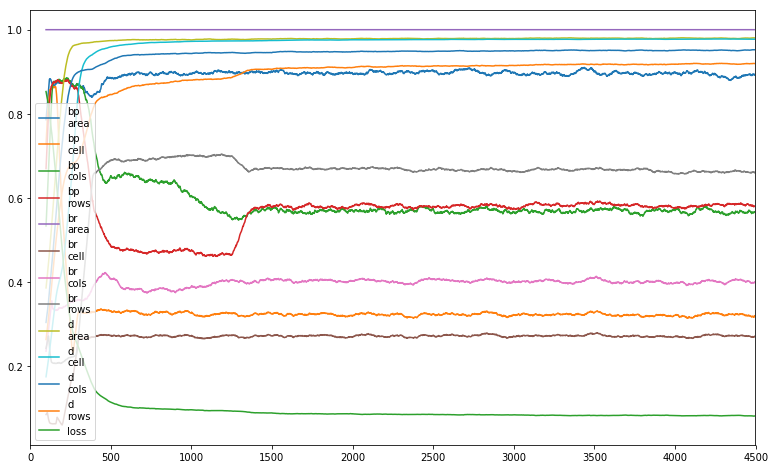

In [35]:
pandas.rolling_mean(train_metrics, 100).plot(figsize=(13, 8))

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  """Entry point for launching an IPython kernel.


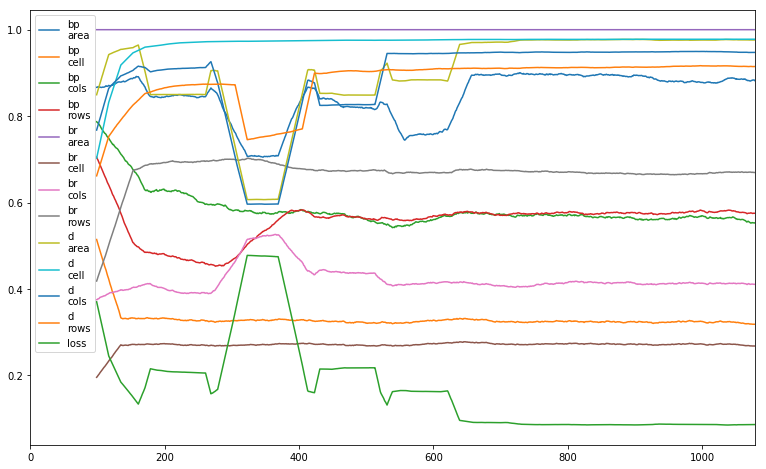

In [34]:
pandas.rolling_mean(val_metrics, 100).plot(figsize=(13, 8))

## Predict and visualize

In [21]:
# torch.save(net, 'models/torch1')

In [22]:
test_net = torch.load('models/torch1').cpu()

In [23]:
# test_net = net.cpu()

In [24]:
test_batch = prepare_batch(val_image_ids[:10], imgaug_pipeline)
test_pred = test_net(npvar(test_batch[1], False))
test_pred_np = test_pred.cpu().data.numpy()

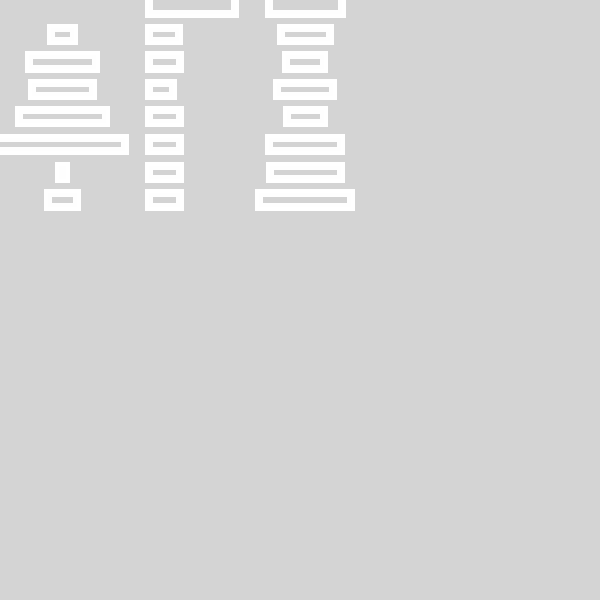

In [25]:
arr_to_img((test_batch[3][3][2] / test_batch[3][3][2].max()) + test_batch[2][3][2])

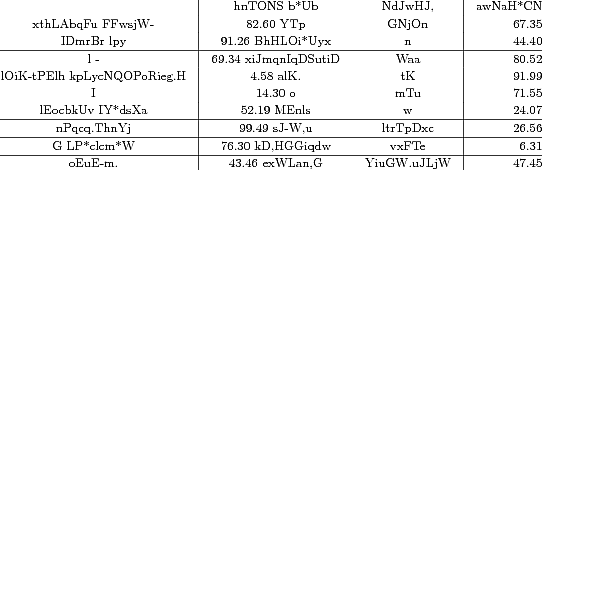

In [26]:
arr_to_img(test_batch[1][6][0])

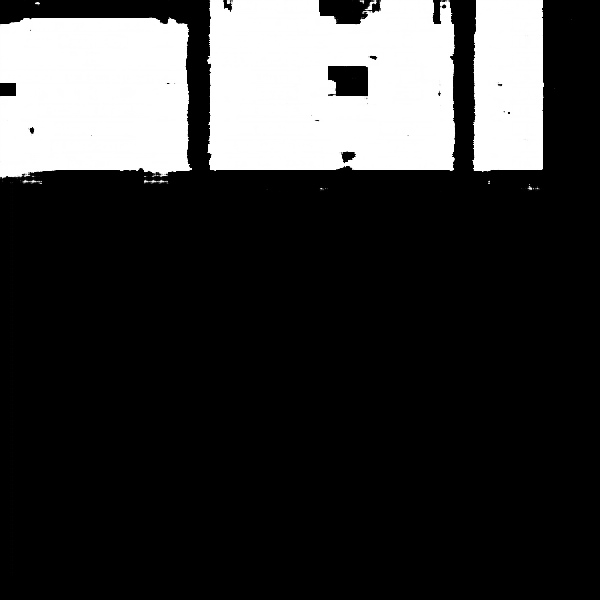

In [27]:
arr_to_img(test_pred_np[6][4])

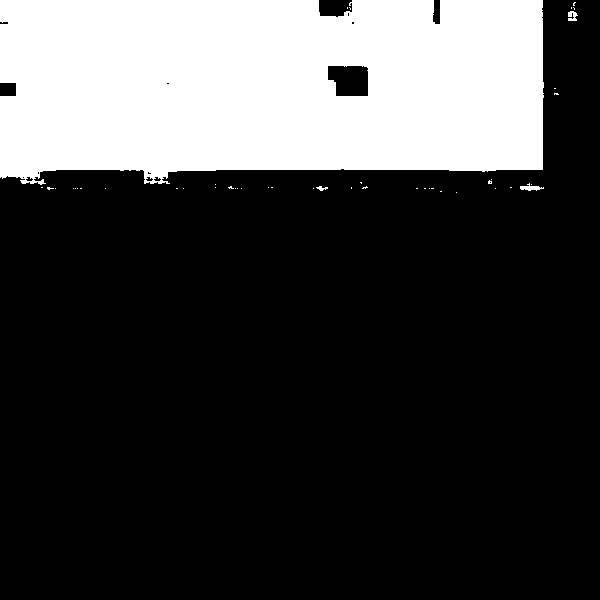

In [28]:
arr_to_img((test_pred_np[6][1] > 0.5).astype('uint8'))